In [1]:
from chainer.links import VGG16Layers
from chainer.links.model.vision.vgg import prepare as VGGprepare
from chainer import Variable
from PIL import Image
import numpy as np
from chainer import Parameter
from chainer import iterators
import chainer.functions as F
from chainer import optimizers,training

#  modelVGG = VGG16Layers()
model = VGG16Layers()
mean = [103.939, 116.779, 123.68]   # BGR

# ILSVSR１２のカテゴリデータ　　https://github.com/HoldenCaulfieldRye/caffe/blob/master/data/ilsvrc12/synset_words.txt
categories = np.loadtxt("synset_words.txt",str,delimiter='\t')

# Google 翻訳サービスを使う
import requests
import re
url = 'https://translate.google.com/?hl=ja#en/ja/'

def translate(estring):
    r = requests.get(url, params={'q': estring})
 
    pattern = "TRANSLATED_TEXT=\'(.*?)\'"
    jstring = re.search(pattern, r.text).group(1)
 
    return jstring
# 確率リストとしての出力からトップ５を出力するメソッド
def showtop5(prob): # prob は最終層から出力される確率リスト（Variable構造体)
    top5args = np.argsort(prob.data)[:-6:-1] # 上位５つの番号
    top5probs = prob.data[top5args] # 上位５つの確率
    for rank,(p,words) in enumerate(zip(top5probs,categories[top5args])):
        print(rank,translate(words))

# 実験１

chainer の predict メソッドと extract メソッドは同じ結果になるかどうか

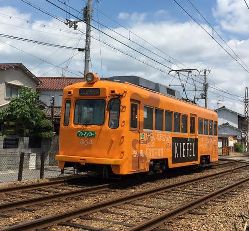

In [2]:
# 対象画像
img = Image.open("train.jpg")
img.resize(np.array(img.size)//2) 

In [3]:
# predict
predict = model.predict([img])[0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04487081トロリーバス、トロリーコーチ、トラックレストロリー


In [4]:
#  extract 
extract= model.extract([img],layers=['prob'])['prob'][0]
showtop5(extract)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n03393912貨物車
3 n04335435電車、電車、電車、トロリー、トロリー車
4 n04310018蒸気機関車


一致した

In [5]:
# numpy array でやってみる。
# predict 
nimg = VGGprepare(img)
print(nimg.shape,np.min(nimg),np.max(nimg))
predict = model.predict([nimg])[0]
showtop5(predict)

(3, 224, 224) -123.68 151.061
0 N04346328 stupa、tope
1 n02966193カルーセル、カルーセル、メリーゴーラウンド、ロータリー、渦巻き
2 n09229709バブル
3 n03598930ジグソーパズル
4 n03089624製菓、菓子、キャンディーストア


In [6]:
# extract
extract= model.extract([nimg],layers=['prob'])['prob'][0]
showtop5(extract)

0 N04346328 stupa、tope
1 n03598930ジグソーパズル
2 n02966193カルーセル、カルーセル、メリーゴーラウンド、ロータリー、渦巻き
3 n04462240トイズショップ
4 n03998194祈りの敷物、祈りのマット


あれっ、認識結果がぜんぜん違う

In [7]:
nimg.shape

(3, 224, 224)

In [8]:
#  NNのバッチ画像データを画像として返すメソッド
def toImage(nnimage,mean): 
    nnimage = (np.dstack(nnimage)+mean)[:,:,::-1]
    def clip(a):
        return 0 if a<0 else (255 if a>255 else a)
    nnimage = np.vectorize(clip)(nnimage)
    npimg = np.uint8(np.round(nnimage ))
    return Image.fromarray(np.uint8(npimg))

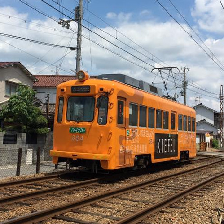

In [9]:
mean = [103.939, 116.779, 123.68]
toImage(nimg,mean=mean)

データ自体は正しい
もしかしたら平均値を引く前のデータでないとだめとか

In [10]:
nimg2 = (np.dstack(nimg)+mean)[:,:,::-1]   # 平均値を加えてやってみる
nimg3 = nimg2.transpose(2,0,1)
print(nimg2.shape, nimg3.shape)

(224, 224, 3) (3, 224, 224)


In [11]:
# predict
predict = model.predict([nimg2])[0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04310018蒸気機関車


In [12]:
extract= model.extract([nimg2],layers=['prob'])['prob'][0]
showtop5(extract)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04310018蒸気機関車


一致した！　ビンゴ

In [13]:
# predict
predict = model.predict([nimg3])[0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04487081トロリーバス、トロリーコーチ、トラックレストロリー


In [14]:
extract= model.extract([nimg3],layers=['prob'])['prob'][0]
showtop5(extract)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04310018蒸気機関車


# サブクラスを作ってやってみたらどうなるか

In [15]:
class MyVGG(VGG16Layers):
    def __init__(self):
        super(MyVGG, self).__init__()

In [16]:
nn = MyVGG()
predict = nn.predict([img])[0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04310018蒸気機関車


おなじ

# 実験２　wrap  メソッドを使わないという選択
predict, extract は平均値を引いたり BGR へ変換したりせずに PIL image や numpy のイメージをそのまま突っ込めるので便利だが、
入力データとNNへの直接入力値とが切り離されているので入力層での微分値が取り出せない
ネット上のいろいろなネタにはこの仕様になる前の情報が多く、随分なやんでしまった

VGG16Layer のソース
https://github.com/chainer/chainer/blob/v2.0.2/chainer/links/model/vision/vgg.py#L33

In [17]:
from chainer import Variable
ximg = VGGprepare(img).reshape(1,3,224,224)
xx = Variable(ximg)

In [18]:
predict = nn.__call__(xx)['prob'][0]
showtop5(predict)

0 n03272562電気機関車
1 n03895866乗用車、コーチ、キャリッジ
2 n03393912貨物車
3 n04335435電車、電車、電車、トロリー、トロリー車
4 n04487081トロリーバス、トロリーコーチ、トラックレストロリー


# バックプロパゲーションのテスト

In [19]:
np.argmax(predict.data)

547

In [20]:
predict[705].backward()

In [21]:
xx.grad

array([[[[  3.34967240e-07,   2.78354082e-06,   2.14520560e-06, ...,
           -1.83971076e-06,  -1.48458230e-06,  -1.28884096e-06],
         [  1.22614949e-06,   4.91057108e-06,   3.04733567e-06, ...,
           -3.34315405e-06,  -2.65012886e-06,  -2.01189118e-06],
         [ -3.76774352e-07,   1.16716046e-06,  -2.36833125e-06, ...,
           -2.26260340e-06,  -3.01431669e-06,  -2.13705448e-06],
         ..., 
         [  1.80607913e-07,  -8.31404918e-07,   1.94185077e-06, ...,
           -4.65007474e-07,   3.41701082e-07,   1.11999576e-07],
         [  7.76608822e-09,  -7.99010820e-07,   1.62941456e-06, ...,
            1.45381784e-06,   1.38888629e-06,   4.55812540e-07],
         [ -5.78715884e-08,  -4.58523971e-07,   6.65104551e-07, ...,
            4.04761408e-07,  -3.10434928e-07,  -3.03031641e-07]],

        [[  2.28158484e-07,   3.05945014e-06,   1.74040224e-06, ...,
           -2.17619174e-07,  -2.50196479e-07,  -6.42644807e-07],
         [  9.15314786e-07,   4.50823109e-06,

よし、逆伝搬できてるみたい

In [22]:
predict = nn(ximg)['prob'][0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04310018蒸気機関車


In [23]:
predict = nn(xx)['prob'][0]
showtop5(predict)

0 n03895866乗用車、コーチ、キャリッジ
1 n03272562電気機関車
2 n04335435電車、電車、電車、トロリー、トロリー車
3 n03393912貨物車
4 n04310018蒸気機関車


そうか、predict や extract を使わなければいいんだ

In [22]:
https://github.com/chainer/chainer/blob/v2.0.2/chainer/links/model/vision/vgg.py#L33

# 実験３

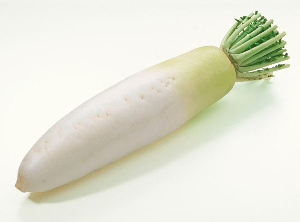

In [24]:
# 対象画像
img = Image.open("d.jpg")
ximg = VGGprepare(img).reshape(1,3,224,224)
xx = Variable(ximg)
img.resize(np.array(img.size)//2) 

In [25]:
predict = nn(ximg)['prob'][0]
showtop5(predict)

0 N03658185レターオープナー、ペーパーナイフ、ペーパーナイフ
1 n03786901モルタル
2 n07753592 banana
3 n13133613耳、スパイク、頭蓋骨
4 n07716906スパゲッティ・スカッシュ


ありゃ、これはひどいね

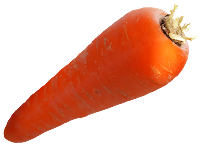

In [13]:
# 対象画像
img２ = Image.open("2.png")
ximg2 = VGGprepare(img2).reshape(1,3,224,224)
xx2 = Variable(ximg2)
img2.resize(np.array(img2.size)//2) 

In [28]:
predict = nn(ximg２)['prob'][0]
showtop5(predict)

0 n07720875ピーマン
1 n07615774アイスロリ、ロリ、ロリポップ、ポピー
2 n07745940ストロベリー
3 n01943899 conch
4 n07747607オレンジ
